In [ ]:
import pandas as pd

df_actual = pd.read_csv('ALL_thumbnail.csv')

### Data Cleaning

In [ ]:
import html

# Decode HTML entities in video_title
df_actual['video_title'] = df_actual['video_title'].apply(html.unescape)

In [ ]:
corpus = df_actual["video_title"].astype(str).tolist()

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and non-alphanumeric characters
    re.sub(r'[^a-zA-Z0-9#\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = text.split()
    # Remove stop words and apply stemming
    tokens = [word for word in tokens if word not in stop_words]
    # commenting it out to make graphs more readable with meaningful words
    # tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    # Join back to string
    return ' '.join(tokens)

df_actual["clean_title"] = df_actual["video_title"].astype(str).apply(clean_text)
corpus = df_actual["clean_title"].tolist()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
ftm = vectorizer.fit_transform(corpus)
ftm_df = pd.DataFrame(ftm.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
print(ftm_df.shape)

(97187, 118689)


In [ ]:
print(len(vectorizer.get_feature_names_out()))  # total number of terms

118689


### Frequent Words

In [ ]:
# Total frequency of each term across all documents
import numpy as np
term_frequencies = np.array(ftm.sum(axis=0)).flatten()
vocab = vectorizer.get_feature_names_out()
term_freq_df = pd.DataFrame({'term': vocab, 'frequency': term_frequencies})
print(term_freq_df.sort_values(by='frequency', ascending=False).head(10))


           term  frequency
97101     video       5057
83546    shorts       3708
98068        vs       3457
67646  official       3427
78162    review       2475
2678       2024       2275
65392       new       2258
63575     music       2134
27632        de       1781
16543      best       1332


In [ ]:
! pip install wordcloud

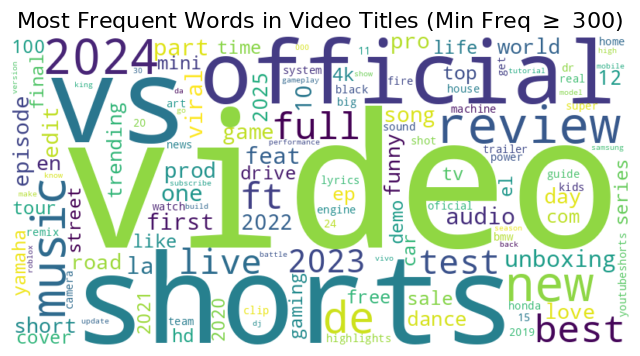

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter for words with frequency >= 300
filtered_df = term_freq_df[term_freq_df['frequency'] >= 300]

# Creating term_freq
word_freq_dict = dict(zip(filtered_df['term'], filtered_df['frequency']))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Video Titles (Min Freq $\geq$ 300)", fontsize=16)
plt.show()

In [ ]:
print(filtered_df.sort_values(by='frequency', ascending=False).head(10))

           term  frequency
97101     video       5057
83546    shorts       3708
98068        vs       3457
67646  official       3427
78162    review       2475
2678       2024       2275
65392       new       2258
63575     music       2134
27632        de       1781
16543      best       1332


In [ ]:
df_actual['publish_time'] = pd.to_datetime(df_actual['publish_time'])

# Extract year from the 'publish_time'
df_actual['publish_year'] = df_actual['publish_time'].dt.year

# Group by year and count the number of videos per year
videos_per_year = df_actual.groupby('publish_year').size()

print(videos_per_year)

publish_year
2005        1
2006       51
2007      170
2008      375
2009      715
2010      800
2011     1062
2012     1458
2013     1733
2014     1818
2015     2237
2016     2654
2017     3026
2018     3893
2019     4512
2020     6816
2021     8207
2022    11056
2023    14504
2024    29566
2025     2533
dtype: int64


In [ ]:
def assign_decade(year):
    if 2005 <= year <= 2009:
        return "2000s"
    elif 2010 <= year <= 2019:
        return "2010s"
    elif 2020 <= year <= 2025:
        return "2020s"
    else:
        return "Other"

df_actual["Decade"] = df_actual["publish_year"].apply(assign_decade)


In [ ]:
# Group by decade and count the number of videos per decade
videos_per_year = df_actual.groupby('Decade').size()

# Display the result
print(videos_per_year)

Decade
2000s     1312
2010s    23193
2020s    72682
dtype: int64


In [ ]:
decades = df_actual["Decade"].dropna().unique()

for decade in sorted(decades):
    # Filter for every decade
    decade_df = df_actual[df_actual["Decade"] == decade]
    corpus = decade_df["clean_title"].astype(str).tolist()

    # Create term frequency
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    term_freq = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out()).T
    term_freq.columns = ["frequency"]
    term_freq = term_freq.reset_index().rename(columns={"index": "term"})

    # Filter for freq >= 50
    filtered = term_freq[term_freq["frequency"] >= 50]
    word_freq_dict = dict(zip(filtered["term"], filtered["frequency"]))

    print(f"\nTop words in {decade} (frequency ≥ 50):")
    print(filtered.sort_values(by="frequency", ascending=False).head(10))



Top words in 2000s (frequency ≥ 50):
          term  frequency
3139     video        122
2164  official         82
2033     music         60

Top words in 2010s (frequency ≥ 50):
           term  frequency
31916     video       1264
22087  official        815
32229        vs        674
25633    review        589
20873     music        389
9298         de        340
21400       new        327
12835        ft        312
29790      test        290
978        2019        265

Top words in 2020s (frequency ≥ 50):
           term  frequency
70884    shorts       3704
82264     video       3671
83084        vs       2758
57415  official       2530
2118       2024       2274
55467       new       1925
66339    review       1874
53929     music       1685
23364        de       1427
13835      best       1174


### Hashtag Usage

In [ ]:
import re

# Extract hashtags from each title into a list
df_actual["hashtags"] = df_actual["clean_title"].apply(lambda x: re.findall(r'#\w+', x))

In [ ]:
# Create a has_hashtag column : True if there is at least one hashtag in the title
df_actual["has_hashtag"] = df_actual["hashtags"].apply(lambda x: len(x) > 0)

# Group by Decade and count titles with hashtags
hashtag_counts = df_actual.groupby("Decade")["has_hashtag"].sum()

# Get total titles per decade
total_titles = df_actual.groupby("Decade")["has_hashtag"].count()

# Combine into a df
hashtag_summary = pd.DataFrame({
    "titles_with_hashtags": hashtag_counts,
    "total_titles": total_titles
})

hashtag_summary["percent_with_hashtags"] = (hashtag_summary["titles_with_hashtags"] / hashtag_summary["total_titles"]) * 100

print(hashtag_summary)


        titles_with_hashtags  total_titles  percent_with_hashtags
Decade                                                           
2000s                     20          1312               1.524390
2010s                    627         23193               2.703402
2020s                  13621         72682              18.740541


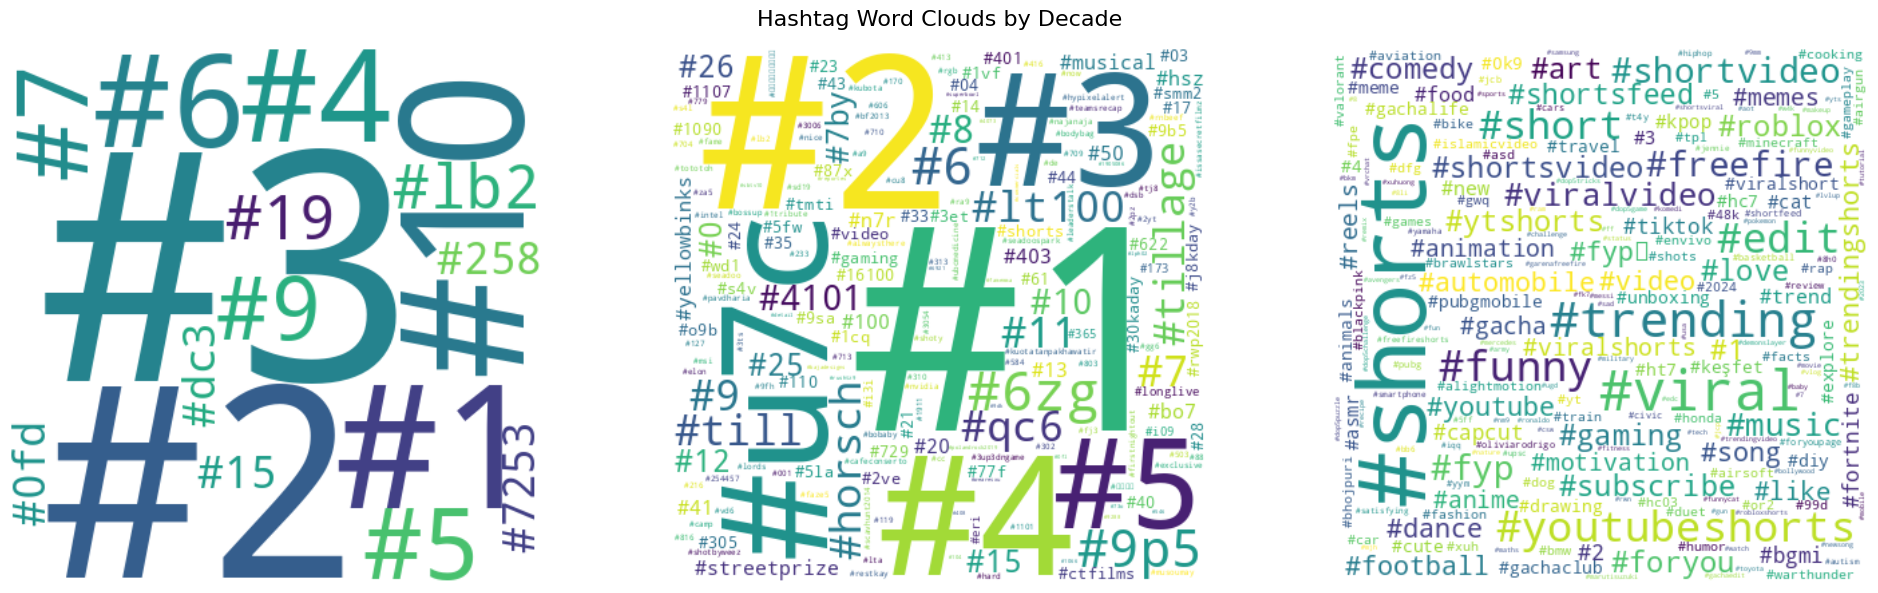

In [ ]:
# Use word cloud to visualize instead
decades = sorted(df_actual["Decade"].dropna().unique())

fig, axes = plt.subplots(1, len(decades), figsize=(20, 6))

for ax, decade in zip(axes, decades):
    decade_df = df_actual[df_actual["Decade"] == decade]
    all_hashtags = [hashtag.lower() for sublist in decade_df["hashtags"] for hashtag in sublist]

    if not all_hashtags:
        ax.set_title(f"No hashtags\n{decade}")
        ax.axis('off')
        continue

    hashtag_counts = Counter(all_hashtags)

    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(hashtag_counts)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

fig.suptitle("Hashtag Word Clouds by Decade", fontsize=16)
plt.tight_layout()
plt.show()


### Emoji Usage

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.7 MB/s eta 0:00:00


In [ ]:
import emoji

# Extract emojis from the text
def extract_emojis(text):
    return [e['emoji'] for e in emoji.emoji_list(text)]

# Apply on video_title column
df_actual['extracted_emojis'] = df_actual['video_title'].apply(extract_emojis)

In [ ]:
df_actual["num_emojis"] = df_actual["extracted_emojis"].apply(len)

In [ ]:
# Boolean column: True if num_emojis > 0
df_actual["has_emoji"] = df_actual["num_emojis"] > 0

# Group by decade
emoji_counts = df_actual.groupby("Decade")["has_emoji"].sum()
total_titles = df_actual.groupby("Decade")["has_emoji"].count()

emoji_summary = pd.DataFrame({
    "titles_with_emojis": emoji_counts,
    "total_titles": total_titles
})

emoji_summary["percent_with_emojis"] = (emoji_summary["titles_with_emojis"] / emoji_summary["total_titles"]) * 100

print(emoji_summary)


        titles_with_emojis  total_titles  percent_with_emojis
Decade                                                       
2000s                    3          1312             0.228659
2010s                  272         23193             1.172768
2020s                 8073         72682            11.107289


In [ ]:
from collections import Counter
import pandas as pd

top_n = 10  # Number of top emojis to show per decade

results = []

for decade in df_actual["Decade"].unique():
    # Filter titles for each decade
    decade_df = df_actual[df_actual["Decade"] == decade]

    # Flatten list of emojis per title, but count each emoji once per title (set)
    emoji_lists = decade_df["extracted_emojis"].apply(set)  # unique emojis per title

    # Count how many titles contain each emoji
    emoji_counter = Counter()
    for emoji_set in emoji_lists:
        emoji_counter.update(emoji_set)

    # Convert to df
    emoji_df = pd.DataFrame(emoji_counter.items(), columns=["emoji", "doc_freq"])
    emoji_df = emoji_df.sort_values(by="doc_freq", ascending=False).head(top_n)
    emoji_df["Decade"] = decade

    results.append(emoji_df)

# Combine all decades
top_emojis_df = pd.concat(results).reset_index(drop=True)

print(top_emojis_df)


   emoji  doc_freq Decade
0      🔥       931  2020s
1      😂       391  2020s
2     ❤️       352  2020s
3      😱       320  2020s
4      😍       295  2020s
5      🤣       252  2020s
6      ✨       201  2020s
7      🔴       188  2020s
8      🥰       181  2020s
9      💥       160  2020s
10     ®        49  2010s
11     ™        38  2010s
12     🔥        14  2010s
13     😍         6  2010s
14     😘         6  2010s
15     🎵         6  2010s
16     ✨         6  2010s
17     🎸         5  2010s
18     ©         5  2010s
19     🔴         5  2010s
20     ®         1  2000s
21     ♥         1  2000s
22     😂         1  2000s
23     🔫         1  2000s


In [ ]:
# Relative frequency of emojis per decade
total_titles_per_decade = df_actual.groupby('Decade').size()
top_n = 10  # Number of top emojis to show per decade

results = []

total_titles_per_decade = df_actual.groupby('Decade').size()

for decade in df_actual["Decade"].unique():
    decade_df = df_actual[df_actual["Decade"] == decade]
    emoji_lists = decade_df["extracted_emojis"].apply(set)  # unique emojis per title

    emoji_counter = Counter()
    for emoji_set in emoji_lists:
        emoji_counter.update(emoji_set)

    emoji_df = pd.DataFrame(emoji_counter.items(), columns=["emoji", "doc_freq"])

    # Calculate relative frequency
    emoji_df["relative_freq"] = emoji_df["doc_freq"] / total_titles_per_decade[decade]

    # Sort by relative frequency and choose top_n
    emoji_df = emoji_df.sort_values(by="relative_freq", ascending=False).head(top_n)
    emoji_df["Decade"] = decade

    results.append(emoji_df)

top_emojis_df = pd.concat(results).reset_index(drop=True)
print(top_emojis_df)


   emoji  doc_freq  relative_freq Decade
0      🔥       931       0.012809  2020s
1      😂       391       0.005380  2020s
2     ❤️       352       0.004843  2020s
3      😱       320       0.004403  2020s
4      😍       295       0.004059  2020s
5      🤣       252       0.003467  2020s
6      ✨       201       0.002765  2020s
7      🔴       188       0.002587  2020s
8      🥰       181       0.002490  2020s
9      💥       160       0.002201  2020s
10     ®        49       0.002113  2010s
11     ™        38       0.001638  2010s
12     🔥        14       0.000604  2010s
13     😍         6       0.000259  2010s
14     😘         6       0.000259  2010s
15     🎵         6       0.000259  2010s
16     ✨         6       0.000259  2010s
17     🎸         5       0.000216  2010s
18     ©         5       0.000216  2010s
19     🔴         5       0.000216  2010s
20     ®         1       0.000762  2000s
21     ♥         1       0.000762  2000s
22     😂         1       0.000762  2000s
23     🔫        

In [ ]:
df_actual['publish_year'] = df_actual['publish_year'].astype(int)

In [ ]:
df_actual['has_emoji'] = df_actual['extracted_emojis'].apply(lambda x: len(x) > 0)

emoji_percent_by_year = df_actual.groupby('publish_year')['has_emoji'].mean() * 100

print(emoji_percent_by_year)

publish_year
2005     0.000000
2006     0.000000
2007     0.588235
2008     0.266667
2009     0.139860
2010     0.000000
2011     0.470810
2012     0.617284
2013     0.288517
2014     0.990099
2015     0.447027
2016     1.168048
2017     1.255783
2018     1.566915
2019     2.105496
2020     3.051643
2021     5.592787
2022     8.122287
2023    10.934915
2024    15.030779
2025    18.870904
Name: has_emoji, dtype: float64


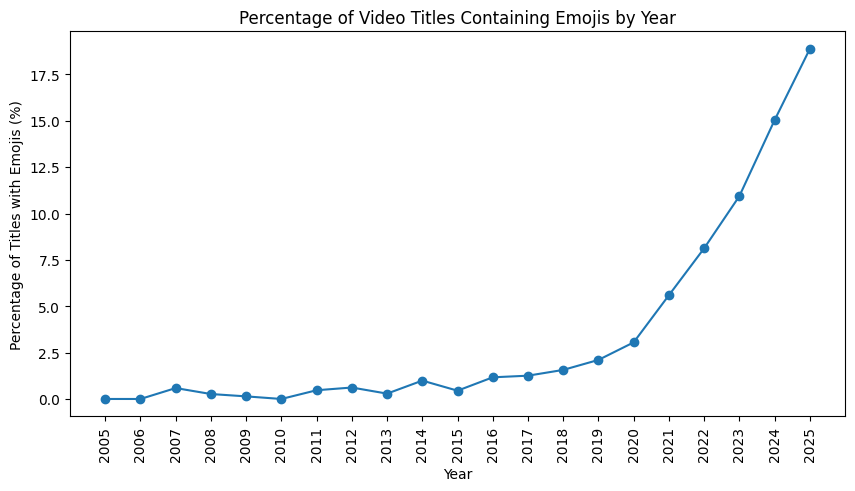

In [ ]:
emoji_percent_by_year.plot(kind='line', figsize=(10,5), marker='o')
plt.xlabel('Year')
plt.ylabel('Percentage of Titles with Emojis (%)')
plt.title('Percentage of Video Titles Containing Emojis by Year')
plt.grid(False)
plt.xticks(emoji_percent_by_year.index.astype(int), rotation = 90)
plt.show()

### Keywords using TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

titles = df_actual['clean_title'].tolist()

vectorizer = TfidfVectorizer(stop_words='english',min_df=15, max_features=1000)  # exclude common stopwords
tfidf_matrix = vectorizer.fit_transform(titles)

feature_names = vectorizer.get_feature_names_out()

def extract_keywords_for_title(title_index, top_n=5):
    # TF-IDF vector for one title
    vector = tfidf_matrix[title_index]

    # Convert to dense array
    scores = vector.toarray()[0]

    # Get indices of top n scores
    top_indices = scores.argsort()[-top_n:][::-1]

    # Map indices to words and scores
    keywords = [(feature_names[i], scores[i]) for i in top_indices if scores[i] > 0]

    return keywords

# Test : print keywords for first title
print(extract_keywords_for_title(0, top_n=5))

[('body', np.float64(0.5622577557822971)), ('anime', np.float64(0.5585356844047502)), ('use', np.float64(0.5164295063280359)), ('shorts', np.float64(0.3243526943050625))]


In [ ]:
grouped = df_actual.groupby('Decade')['clean_title'].apply(lambda x: ' '.join(x)).reset_index()
# Vectorize grouped text (one document per year_group)
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(grouped['clean_title'])

feature_names = vectorizer.get_feature_names_out()
def get_top_keywords_for_doc(doc_vector, feature_names, top_n=5):
    scores = doc_vector.toarray()[0]
    top_indices = scores.argsort()[-top_n:][::-1]
    return [(feature_names[i], scores[i]) for i in top_indices if scores[i] > 0]

grouped['top_keywords'] = grouped.apply(
    lambda row: get_top_keywords_for_doc(tfidf_matrix[row.name], feature_names, top_n=5),
    axis=1
)

print(grouped[['Decade', 'top_keywords']])
for idx, row in grouped.iterrows():
    print(f"Decade: {row['Decade']}")
    for word, score in row['top_keywords']:
        print(f"  {word}: {score:.3f}")
    print()

  Decade                                       top_keywords
0  2000s  [(video, 0.6442863213665526), (official, 0.433...
1  2010s  [(video, 0.5151328975488717), (official, 0.332...
2  2020s  [(shorts, 0.4575921634839515), (video, 0.35219...
Decade: 2000s
  video: 0.644
  official: 0.433
  music: 0.317
  2009: 0.148
  demo: 0.132

Decade: 2010s
  video: 0.515
  official: 0.332
  vs: 0.275
  review: 0.240
  music: 0.159

Decade: 2020s
  shorts: 0.458
  video: 0.352
  2024: 0.281
  vs: 0.265
  official: 0.243



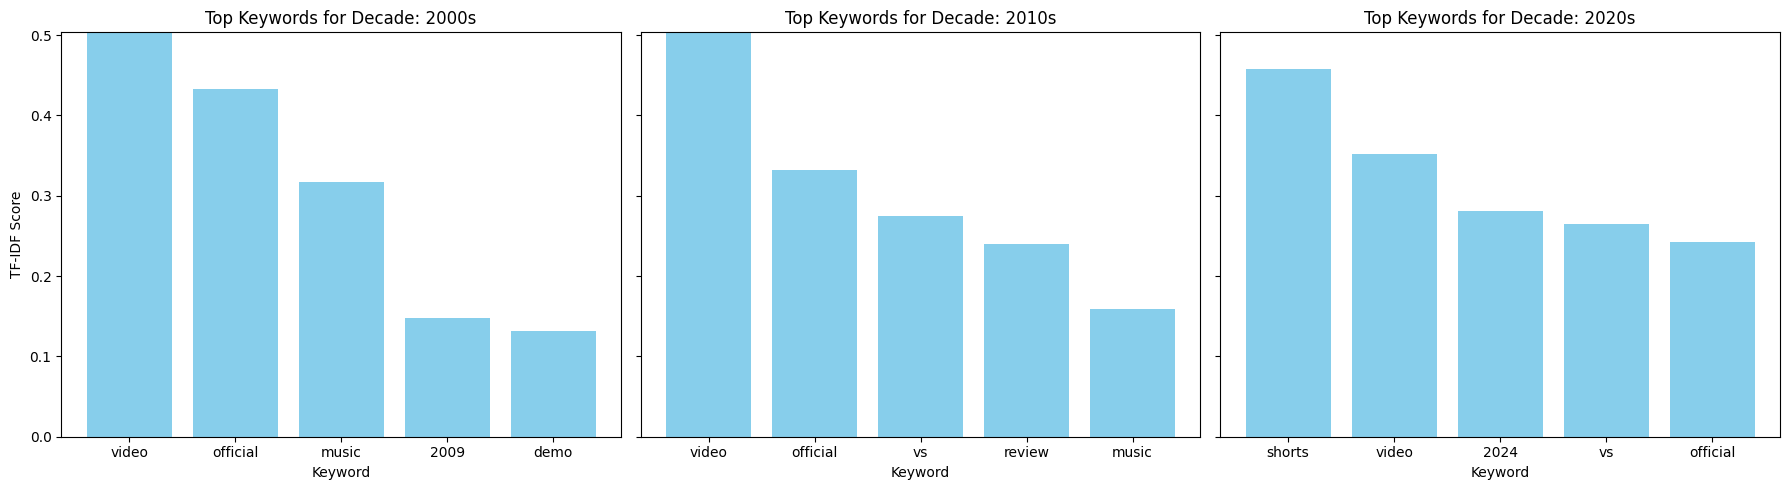

In [ ]:
decades = grouped['Decade'].tolist()
num_decades = len(decades)

fig, axes = plt.subplots(1, num_decades, figsize=(6 * num_decades, 5), sharey=True)

for i, (idx, row) in enumerate(grouped.iterrows()):
    keywords = row['top_keywords']
    if not keywords:
        continue
    words, scores = zip(*keywords)

    ax = axes[i] if num_decades > 1 else axes
    ax.bar(words, scores, color='skyblue')
    ax.set_title(f"Top Keywords for Decade: {row['Decade']}")
    ax.set_xlabel("Keyword")
    if i == 0:
        ax.set_ylabel("TF-IDF Score")
    ax.set_ylim(0, max(scores) * 1.1)

plt.tight_layout()
plt.show()


### Word Correlation Graph

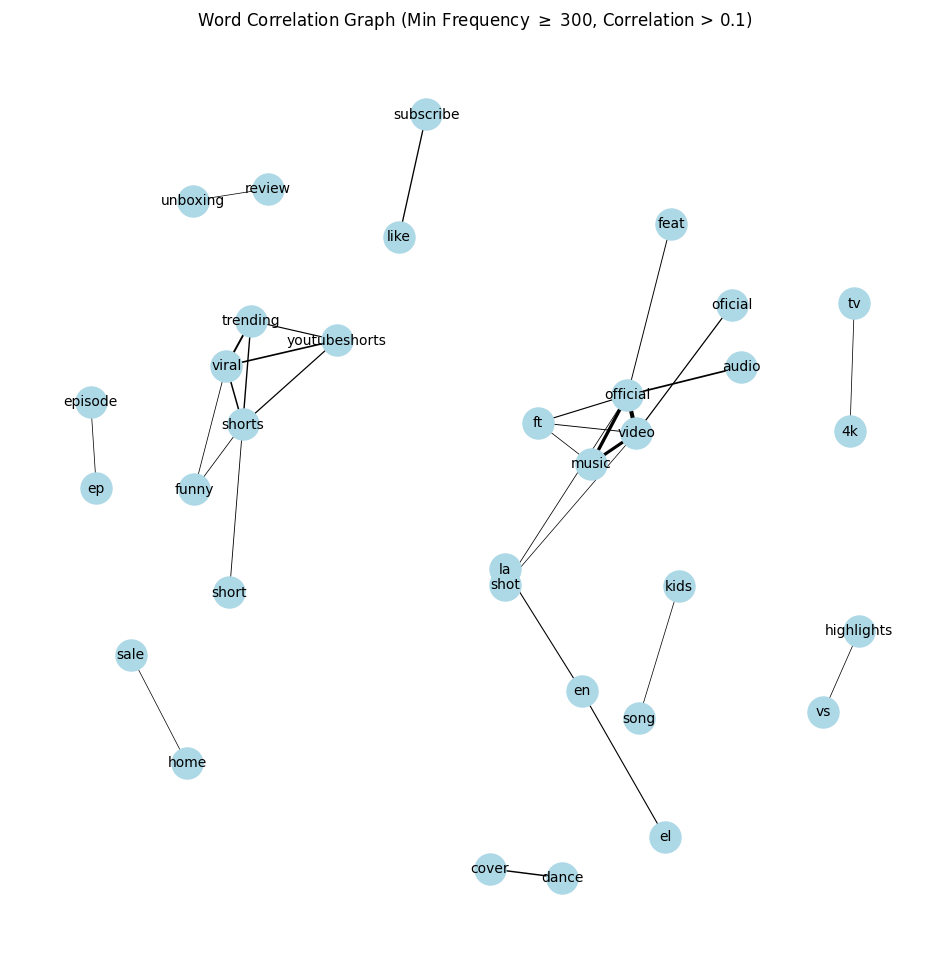

In [ ]:
# Word correlation graph
import numpy as np
import networkx as nx

corpus = df_actual['clean_title'].tolist()

# Create term-document matrix
vectorizer = CountVectorizer(min_df=300, stop_words='english')
X = vectorizer.fit_transform(corpus)

# Calculate co-occurrence matrix (word-word)
# co-occurrence = X.T * X (term-term matrix)
co_occurrence = (X.T @ X).toarray()

# Convert to correlation matrix
# Normalize to get correlation-like values
diag = np.diag(co_occurrence)
denom = np.sqrt(np.outer(diag, diag))
correlation_matrix = co_occurrence / denom
np.fill_diagonal(correlation_matrix, 0)  # remove self correlations

# Build network of words with correlations above a threshold
terms = vectorizer.get_feature_names_out()
threshold = 0.1

G = nx.Graph()

# Adding nodes for each word
for term in terms:
    G.add_node(term)

# Adding edges for correlated pairs
for i in range(len(terms)):
    for j in range(i+1, len(terms)):
        if correlation_matrix[i, j] > threshold:
            G.add_edge(terms[i], terms[j], weight=correlation_matrix[i, j])

# Removing isolated nodes (words with no correlations to other words)
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# Plot
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.3)
# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight']*5 for (u,v,d) in edges])
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Word Correlation Graph (Min Frequency $\geq$ 300, Correlation > 0.1)")
plt.axis('off')
plt.show()


In [ ]:
print("Nodes:", list(G.nodes()))
print("Top edges with weights:")
for u, v, d in sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:15]:
    print(f"{u} - {v}: {d['weight']:.2f}")

Nodes: ['4k', 'audio', 'cover', 'dance', 'el', 'en', 'ep', 'episode', 'feat', 'ft', 'funny', 'highlights', 'home', 'kids', 'la', 'like', 'music', 'official', 'oficial', 'review', 'sale', 'short', 'shorts', 'shot', 'song', 'subscribe', 'trending', 'tv', 'unboxing', 'video', 'viral', 'vs', 'youtubeshorts']
Top edges with weights:
official - video: 0.59
music - official: 0.48
music - video: 0.45
trending - viral: 0.28
audio - official: 0.25
viral - youtubeshorts: 0.24
shorts - viral: 0.22
cover - dance: 0.21
shorts - trending: 0.20
like - subscribe: 0.19
oficial - video: 0.18
shorts - youtubeshorts: 0.18
trending - youtubeshorts: 0.16
ft - official: 0.16
el - en: 0.16


### Bigrams and Trigrams

In [ ]:
co = CountVectorizer(ngram_range=(2, 2))

counts = co.fit_transform(df_actual["clean_title"])

ngram_counts = counts.sum(axis=0)

# Total count of all bigrams
total_ngrams = ngram_counts.sum()

# Calculate relative frequency in percentage
relative_freq = (ngram_counts / total_ngrams) * 100

ngram_freq_df = pd.DataFrame(relative_freq.T, index=co.get_feature_names_out(), columns=["relative_frequency"])

top_ngrams = ngram_freq_df.sort_values(by="relative_frequency", ascending=False).head(10)

print(top_ngrams)

                relative_frequency
music video               0.269411
official music            0.231942
official video            0.180948
official audio            0.077497
video oficial             0.043501
lyric video               0.042404
clip officiel             0.040211
full episode              0.035276
samsung galaxy            0.029427
free fire                 0.027782


In [ ]:
co = CountVectorizer(ngram_range=(3, 3))

counts = co.fit_transform(df_actual["clean_title"])

ngram_counts = counts.sum(axis=0)

# Count total no. of bigrams
total_ngrams = ngram_counts.sum()

# Calculating relative frequency
relative_freq = (ngram_counts / total_ngrams) * 100

ngram_freq_df = pd.DataFrame(relative_freq.T, index=co.get_feature_names_out(), columns=["relative_frequency"])

top_ngrams = ngram_freq_df.sort_values(by="relative_frequency", ascending=False).head(10)

print(top_ngrams)

                      relative_frequency
official music video            0.271683
official lyric video            0.026618
music video shot                0.017599
official video shot             0.011219
super mario maker               0.010999
everything need know            0.009679
vivo y52 5g                     0.009459
mehta ka ooltah                 0.009239
italian u2 tribute              0.009239
ka ooltah chashmah              0.009239


### Clickbait using Hugging Transformers

In [ ]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from tqdm import tqdm

# Loading model & tokenizer
model_name = "valurank/distilroberta-clickbait"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def batch_predict_clickbait(texts, batch_size=32):
    all_labels = []
    all_scores = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenize batch
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)

        preds = torch.argmax(probs, dim=1).cpu().tolist()
        confidences = probs.max(dim=1).values.cpu().tolist()

        labels = ["Clickbait" if p == 1 else "Not Clickbait" for p in preds]

        all_labels.extend(labels)
        all_scores.extend(confidences)

    return all_labels, all_scores

titles = df_actual['video_title'].fillna('').tolist()

# Run batch predictions separately
title_labels, title_scores = batch_predict_clickbait(titles, batch_size=64)

# Assign back to dataframe
df_actual['clickbait_label_title'] = title_labels
df_actual['clickbait_score_title'] = title_scores

print(df_actual[['video_title', 'clickbait_label_title', 'clickbait_score_title']].head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

100%|██████████| 1519/1519 [00:49<00:00, 30.68it/s]

                                         video_title clickbait_label_title  \
0  When Quest Users Use Full Body Tracking in VRC...         Not Clickbait   
1                     VRC Physics explained by a pro         Not Clickbait   
2  When Your Friend Is Quest User #vrchat #anime ...             Clickbait   
3  Homie got you covered #shorts #vrchat #virtual...             Clickbait   
4                        your first 12 months of VRC         Not Clickbait   

   clickbait_score_title  
0               0.961778  
1               0.999913  
2               0.999625  
3               0.869227  
4               0.998146  


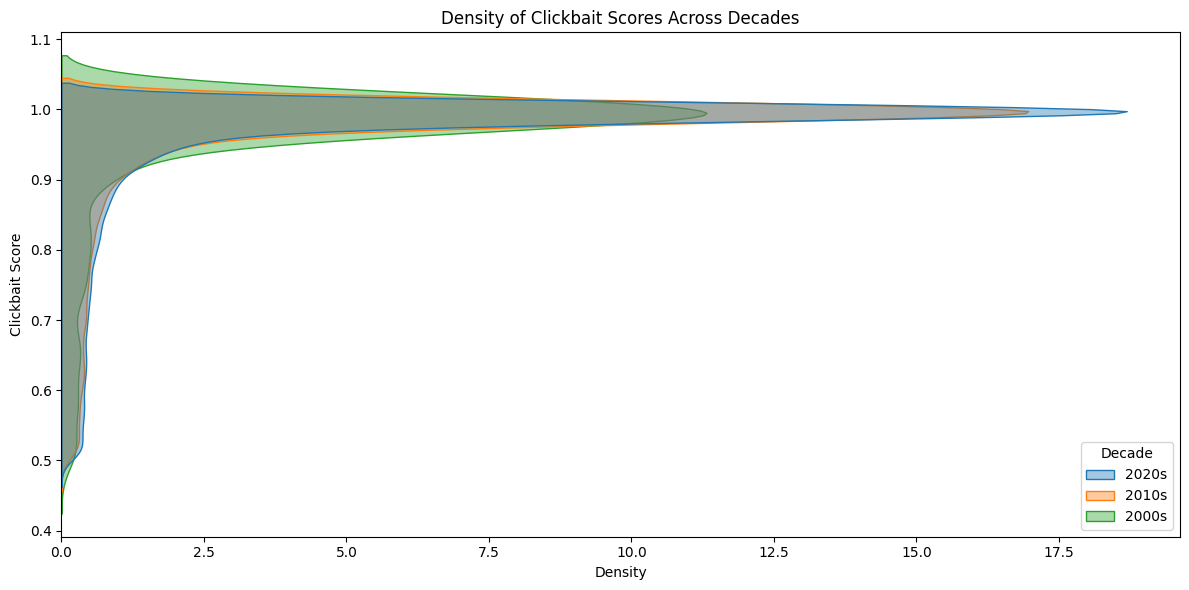

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_actual, y='clickbait_score_title', hue='Decade', common_norm=False, fill=True, alpha=0.4, palette='tab10')
plt.title("Density of Clickbait Scores Across Decades")
plt.ylabel("Clickbait Score")
plt.xlabel("Density")
plt.tight_layout()
plt.show()